In [1]:
import pandas as pd
import seaborn as sns
sns.set(context='poster', font_scale=1.2, style='white')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import the CSV data into Pandas dataframes

In [2]:
test_results = pd.read_csv('./test_results.csv')
user_table = pd.read_csv('./user_table.csv')

In [3]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


Background: 
Company XYZ sells a software for \$39. Since revenue has been flat for some time, the VP of
Product has decided to run a test increasing the price. She hopes that this would increase
revenue. In the experiment, 66% of the users have seen the old price ($39), while a random
sample of 33% users a higher price (\$59).
The test has been running for some time and the VP of Product is interested in understanding
how it went and whether it would make sense to increase the price for all the users.

Questions to ask:

Should the company sell its software for \$39 or $59?

The VP of Product is interested in having a holistic view into user behavior, especially
focusing on actionable insights that might increase conversion rate. What are your main
findings looking at the data?

[Bonus] The VP of Product feels that the test has been running for too long and she should
have been able to get statistically significant results in a shorter time. Do you agree with
her intuition? After how many days you would have stopped the test? Please, explain
why.

In [5]:
test_results.groupby(['price'])['converted'].count()

price
39    202672
59    114128
Name: converted, dtype: int64

In [6]:
test_results.groupby(['price', 'converted'])['converted'].count()

price  converted
39     0            198641
       1              4031
59     0            112351
       1              1777
Name: converted, dtype: int64

Okay, first I need to figure out the conversion rate at each price point.

In [7]:
conversion_rate = test_results.groupby(['price'])['converted'].mean()

In [8]:
conversion_rate

price
39    0.019889
59    0.015570
Name: converted, dtype: float64

Okay, so people who saw the lower price bought the product at a higher rate. But is it high enough to offset the difference in price?

In [9]:
lower_price_return = 39*0.019889
higher_price_return = 59*0.01557
lower_price_return, higher_price_return

(0.775671, 0.9186300000000001)

Looks like on average, we earn \$0.92 per visitor with the higher price and $0.78 per visitor with the lower price. So the company should switch.

I can formalize this analysis more by stating some hypotheses and including information about our sample size. The 'break-even' point for the new higher price is 59\*x = 39\*y, where x and y are the conversion rates at each price. So if x > 39y/59, the company should switch to the higher price. If x <= 39y/59, the company should not switch.

My null hypothesis is x <= 39y/59, which would lead to no price change.
The alternate hypothesis is x > 39y/59, which would lead to a price increase.

In [13]:
x = 0.01557
y = 0.019889
print 39*y/59
x > 39*y/59

0.0131469661017


True

In [11]:
r = test_results['converted'].mean()
diff = y - x
SE = sqrt(r*(1-r)*((1/202672.)+(1/114128.)))
diff/SE

8.6992308929800117

I can test whether the rates x and y depend on the version of price using a chi-squared test for independence.

In [12]:
from scipy.stats import chi2_contingency
observed = np.array([[198641, 4031], [112351, 1777]])
#print observed
chi2, p, dof, ex = chi2_contingency(observed)
print 'chisq = {}, p = {}'.format(chi2, p)

chisq = 75.4383069939, p = 3.77004282817e-18


Well, they are definitely different, which is not surprising. What I want to know is if the rate for the $59 price is higher than 0.013147, the break-even point.

In [29]:
from scipy.stats import t
n = 114128  # sample number for $59 price
sv = (x*(1-x))/n  # sample variance
t_stat = (x-0.0131469661017)/np.sqrt(sv/float(n))  # t-statistic for proportion
pval = t.sf(t_stat, n-1)  # one-sided pvalue = Prob(t>tt)
print 't-statistic = %6.3f pvalue = %6.10f' % (t_stat, pval)

t-statistic = 2233.649 pvalue = 0.0000000000


Not sure if I'm calculating that correctly, but I'll go with it.

Let's try to plot the conversion rate over time.

In [14]:
test_results.tail()

,user_id,timestamp,source,device,operative_system,test,price,converted
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0
316799,832372,2015-03-08 17:12:33,ads_facebook,mobile,android,1,59,0


In [15]:
test_results['timestamp'].replace(to_replace=':60', value=':59', inplace=True, regex=True)

In [16]:
ordered_test_results = test_results.sort_values(by='timestamp')
ordered_test_results['timestamp'] = pd.to_datetime(ordered_test_results['timestamp'], format='%Y%m%d %H:%M:%S')

In [47]:
ordered_results_39 = ordered_test_results[ordered_test_results.price == 39].reset_index()
ordered_results_59 = ordered_test_results[ordered_test_results.price == 59].reset_index()
ordered_results_39['cum_converted'] = ordered_results_39['converted'].cumsum()
ordered_results_39['cum_count'] = ordered_results_39.index.values + 1
ordered_results_39['cum_rate'] = ordered_results_39['cum_converted'].div(ordered_results_39['cum_count'])
ordered_results_59['cum_converted'] = ordered_results_59['converted'].cumsum()
ordered_results_59['cum_count'] = ordered_results_59.index.values + 1
ordered_results_59['cum_rate'] = ordered_results_59['cum_converted'].div(ordered_results_59['cum_count'])

In [48]:
ordered_results_39.tail()

,index,user_id,timestamp,source,device,operative_system,test,price,converted,cum_converted,cum_count,cum_rate
202667,102840,779865,2015-05-31 23:52:41,ads-google,mobile,iOS,0,39,0,4031,202668,0.019890
202668,309275,281578,2015-05-31 23:52:41,ads-google,mobile,iOS,0,39,0,4031,202669,0.019890
202669,142938,184420,2015-05-31 23:54:59,seo_facebook,mobile,iOS,0,39,0,4031,202670,0.019889
202670,246297,891559,2015-05-31 23:54:59,seo_facebook,mobile,iOS,0,39,0,4031,202671,0.019889
202671,205994,184998,2015-05-31 23:59:45,ads-bing,web,windows,0,39,0,4031,202672,0.019889


In [55]:
ordered_results_59.head()

,index,user_id,timestamp,source,device,operative_system,test,price,converted,cum_converted,cum_count,cum_rate,p-value
0,215757,813537,2015-03-02 00:04:12,ads-google,web,windows,1,59,0,0,1,0.0,NaN
1,166052,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59,0,0,2,0.0,1.0
2,223056,434444,2015-03-02 00:22:21,ads-google,web,windows,1,59,0,0,3,0.0,1.0
3,316162,144393,2015-03-02 00:22:21,ads-google,web,windows,1,59,0,0,4,0.0,1.0
4,186251,428171,2015-03-02 00:22:21,ads-google,web,windows,1,59,0,0,5,0.0,1.0


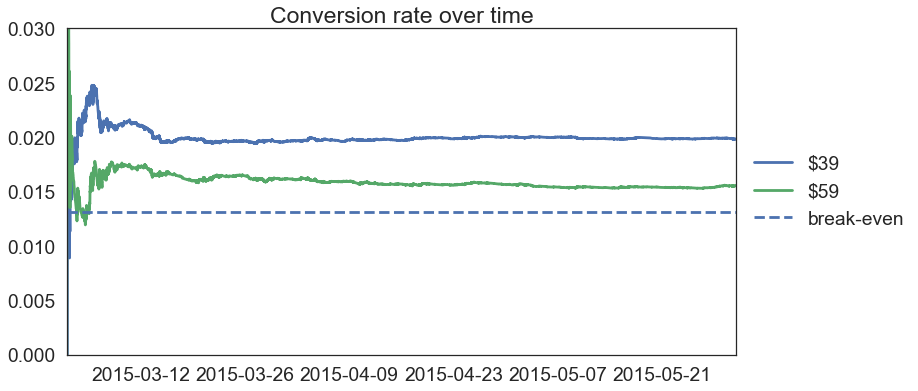

In [64]:
import datetime
enddate = datetime.datetime(2015,5,31)
startdate = datetime.datetime(2015,3,2)

fig = plt.figure(figsize(12, 6))
ax = plt.axes()
ax.plot(ordered_results_39.timestamp, ordered_results_39.cum_rate, label='$39')
ax.plot(ordered_results_59.timestamp, ordered_results_59.cum_rate, label='$59')
plt.axhline(0.0131469661017, linestyle='--', label='break-even')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 0.03)
ax.set_xlim(startdate, enddate)
plt.title('Conversion rate over time')
plt.show()

Now I'd like to plot the p-value for the difference between the \$59 conversion rate and the break-even point over time.

In [51]:
def find_pval(row):
    n = row.cum_count
    x = row.cum_rate
    sv = (x*(1-x))/n  # sample variance
    t_stat = (x-0.0131469661017)/np.sqrt(sv/float(n))  # t-statistic for proportion
    return t.sf(t_stat, n-1)  # one-sided pvalue = Prob(t>tt)

test_pval = ordered_results_59.apply(lambda x: find_pval(x), axis=1)

/anaconda/envs/my_insight_env/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


In [54]:
ordered_results_59['p-value'] = test_pval

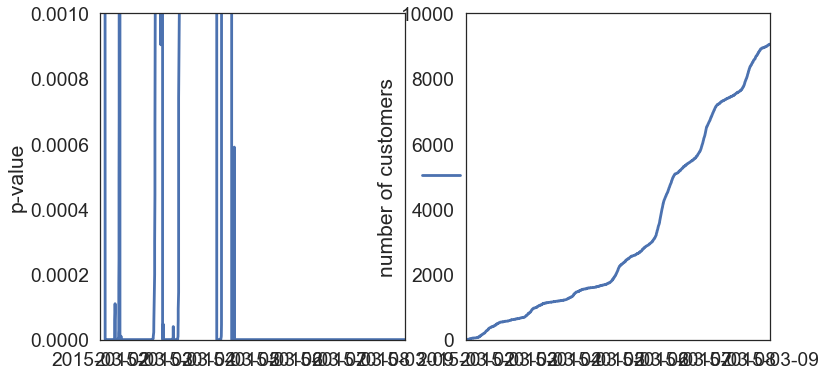

In [81]:
enddate = datetime.datetime(2015,3,9)
startdate = datetime.datetime(2015,3,2)
# fig = plt.figure(figsize(12, 6))
fig, ax = plt.subplots(1, 2)
ax[0].plot(ordered_results_59.timestamp, ordered_results_59['p-value'])
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylim(0, 0.001)
ax[0].set_ylabel('p-value')
ax[0].set_xlim(startdate, enddate)
ax[1].plot(ordered_results_59.timestamp, ordered_results_59['cum_count'])
ax[1].set_ylim(0, 10000)
ax[1].set_ylabel('number of customers')
ax[1].set_xlim(startdate, enddate)
plt.show()

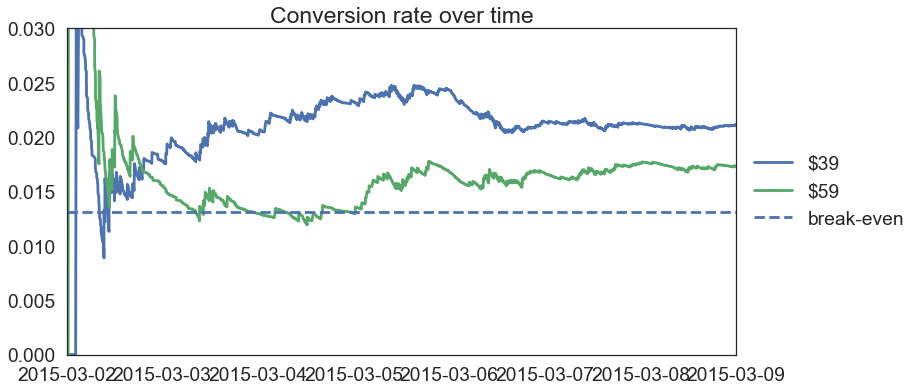

In [63]:
import datetime
enddate = datetime.datetime(2015,3,9)
startdate = datetime.datetime(2015,3,2)

fig = plt.figure(figsize(12, 6))
ax = plt.axes()
ax.plot(ordered_results_39.timestamp, ordered_results_39.cum_rate, label='$39')
ax.plot(ordered_results_59.timestamp, ordered_results_59.cum_rate, label='$59')
plt.axhline(0.0131469661017, linestyle='--', label='break-even')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 0.03)
ax.set_xlim(startdate, enddate)
plt.title('Conversion rate over time')
plt.show()

It's pretty clear that both of the conversion rates and the p-value stabilize by one week into the A/B testing. The length of the testing would depend on how sure the company needs to be before being comfortable changing the price, but I would recommend switching to the higher price after a week of testing. The CEO is correct that the test went on for much longer than necessary.

Now let's look at all of the other information on our users. I'll plot conversion rate for each variable (source, device, OS) and other features like time of day and location.

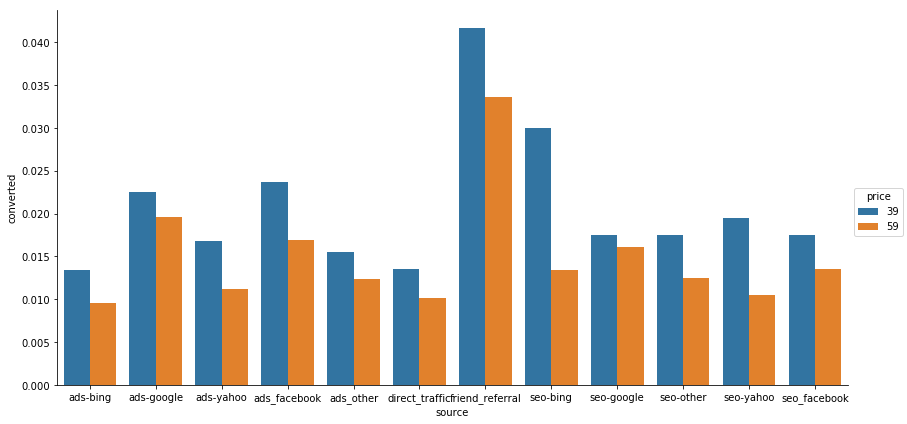

In [30]:
source_series = test_results.groupby(['price', 'source'])['converted'].mean()
source_converted = source_series.reset_index()
sns.factorplot(x='source', y='converted', data=source_converted, hue='price', kind='bar', size=6, aspect=2)
plt.show()

In [65]:
test_results.groupby(['price', 'source'])['converted'].count()

price  source         
39     ads-bing           14601
       ads-google         37863
       ads-yahoo           4818
       ads_facebook       34090
       ads_other          19278
       direct_traffic     38750
       friend_referral    13124
       seo-bing            1333
       seo-google         15101
       seo-other           5885
       seo-yahoo           4356
       seo_facebook       13473
59     ads-bing            8272
       ads-google         21516
       ads-yahoo           2765
       ads_facebook       19306
       ads_other          10598
       direct_traffic     21607
       friend_referral     7571
       seo-bing             820
       seo-google          8074
       seo-other           3375
       seo-yahoo           2492
       seo_facebook        7732
Name: converted, dtype: int64

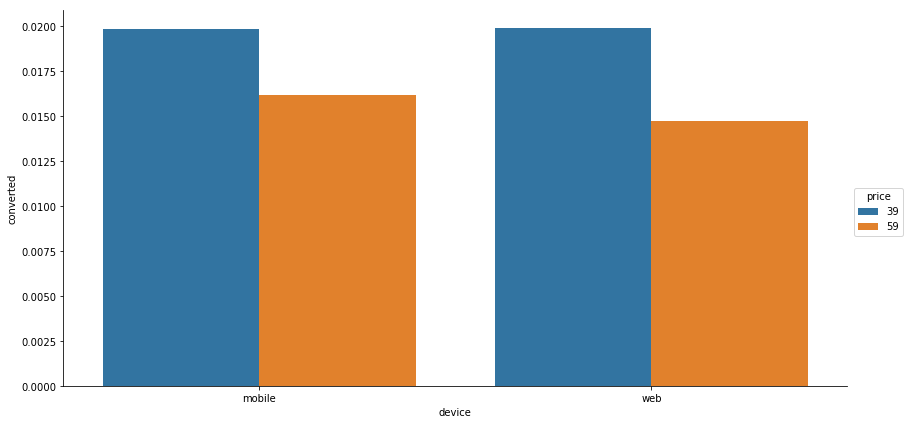

In [29]:
device_series = test_results.groupby(['price', 'device'])['converted'].mean()
device_converted = device_series.reset_index()
sns.factorplot(x='device', y='converted', data=device_converted, hue='price', kind='bar',size=6, aspect=2)
plt.show()

In [66]:
test_results.groupby(['price', 'device'])['converted'].count()

price  device
39     mobile    120461
       web        82211
59     mobile     66010
       web        48118
Name: converted, dtype: int64

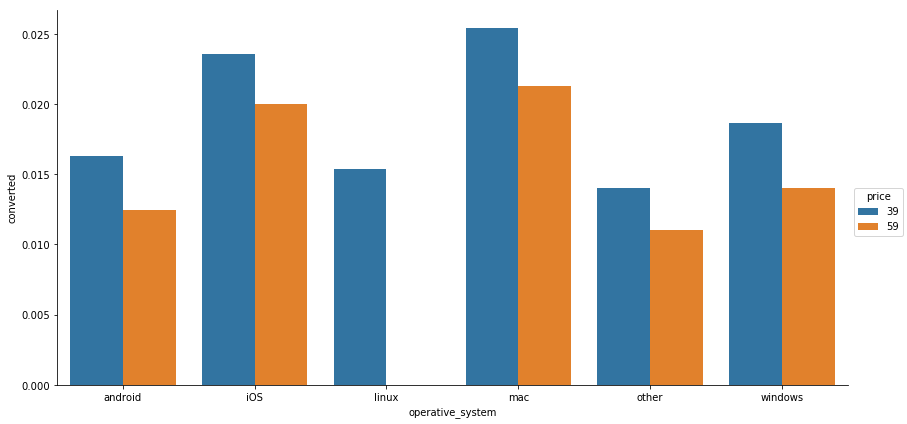

In [28]:
os_series = test_results.groupby(['price', 'operative_system'])['converted'].mean()
os_converted = os_series.reset_index()
sns.factorplot(x='operative_system', y='converted', data=os_converted, hue='price', kind='bar',size=6, aspect=2)
plt.show()

In [67]:
test_results.groupby(['price', 'operative_system'])['converted'].count()

price  operative_system
39     android             48209
       iOS                 61843
       linux                2206
       mac                 16354
       other               10491
       windows             63569
59     android             26726
       iOS                 33622
       linux                1929
       mac                  8731
       other                5713
       windows             37407
Name: converted, dtype: int64